<a href="https://colab.research.google.com/github/dev-SR/Deep-Learning/blob/main/02-FFN-pytorch/ffn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Building FeedForward Networks with `Pytorch`


**Deep feedforward networks**, also called **feedforward neural networks**, or multilayer perceptrons (MLPs), are the quintessential deep learning models.The goal of a feedforward network is to approximate some function
$f*$. These models are called _feedforward_ because there are no _feedback_ connections. A general form of a deep feedforward network can be represented by:

$$
f(\textbf{x}) = f^{(n)}(f^{(n-1)}(\cdots(f^{(2)}(f^{(1)}(\textbf{x})))))
$$


## Init


In [7]:
"""
cd 02-pytorch-mlp-hands-on
jupyter nbconvert --to markdown ffn.ipynb --output README.md
"""
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt

from helper import plot_gradient_one_var, plot_gradient_descent_one_var
import sys

sys.path.append("..")  # Add the parent directory to the path
from plot import plot_decision_regions  # noqa: E402

from global_helpers import (  # noqa: E402
    generate_blob_cluster,
    compute_mse_and_acc,
    minibatch_generator,
    int_to_onehot,
)

## The formal definition of an artificial neuron


More formally, we can put the idea behind artificial neurons into the context of a binary classification
task with two classes: 0 and 1. We can then define a decision function, $\sigma$, that takes a linear
combination of certain input values, $x$, and a corresponding weight vector, $w$, where $z$ is the so-called
net input:

$$\mathbf{z} = w_1x_1 + w_2x_2 + \ldots + w_mx_m$$

Vector form:

$$
w= \begin{bmatrix}
    w_1 \\
    \vdots \\
    w_m
\end{bmatrix},
x= \begin{bmatrix}
    x_1 \\
    \vdots \\
    x_m
\end{bmatrix}
$$

Now, if the net input of a particular example, $x^{(i)}$, is greater than a defined threshold, $th$, we predict class 1, and class 0 otherwise. In the perceptron algorithm, the decision function, $\sigma(\cdot)$, is a variant of a unit step function:

$$
\sigma(z) =
\begin{cases}
    1 & \text{if } \mathbf{z} \geq th \\
    0 & \text{otherwise}
\end{cases}
$$

To simplify the code implementation later, we can modify this setup via a couple of steps. First, we move the threshold, $th$, to the left side of the equation:

$$
z \geq th \\
z -th \geq 0
$$

Second, we define a so-called bias unit as $b = -th$ and make it part of the net input:

$$
z = w_1x_1 + \ldots + w_mx_m + b = \mathbf{w}^T\mathbf{x} + b
$$

<p align="center">
<img src="img/02_02_unit_function.png" alt="02_02_unit_function.png" width="600px"/>
</p>


## The perceptron learning rule


The whole idea behind the MCP neuron and **Rosenblatt’s thresholded perceptron model** is to use a reductionist approach to mimic how a single neuron in the brain works: _it either fires or it doesn’t_. Thus,
Rosenblatt’s classic perceptron rule is fairly simple, and the perceptron algorithm can be summarized
by the following steps:

1. Initialize the weights and bias unit to `0` or small random numbers
2. For each training example, $x^{(i)}$:
   1. Compute the output value, $y^{(i)}$
   2. Update the weights and bias unit

Here, the output value is the class label predicted by the **unit step function** that we defined earlier, and the simultaneous update of the bias unit and each weight, $w_j$, in the weight vector, $w$, can be more
formally written as:

$$w_j \leftarrow w_j + \Delta w_j \quad \text{and} \quad b \leftarrow b + \Delta b$$

The update values (“deltas”) are computed as follows:

$$\Delta w_j = \eta \cdot (y^{(i)} - \hat{y}^{(i)}) \cdot x_j^{(i)}$$

$$\Delta b = \eta \cdot (y^{(i)} - \hat{y}^{(i)})$$

Each weight, $w_j$, corresponds to a feature, $x_j$, in the dataset, which is involved in determining the update value, $\Delta w_{ij}$, defined above. Furthermore, $\eta$ is the learning rate (typically a constant between 0.0 and 1.0), $y^{(i)}$ is the true class label of the $i$th training example, and $y^{(i)}$ is the predicted class label. It is important to note that the bias unit and all weights in the weight vector are being updated simultaneously, which means that we don’t recompute the predicted label, $y^{(i)}$, before the bias unit and all of the weights are updated via the respective update values, $\Delta w_{ij}$ and $\Delta b$.

In the two scenarios where the perceptron predicts the class label correctly, the bias unit and weights remain unchanged, since the update values are 0:

- $y^{(i)} = 0$, $y^{(i)} = 0$, $\Delta w_{ij} = \eta(0 - 0)x_j = 0$, $\Delta b = \eta(0 - 0) = 0$
- $y^{(i)} = 1$, $y^{(i)} = 1$, $\Delta w_{ij} = \eta(1 - 1)x_j = 0$, $\Delta b = \eta(1 - 1) = 0$

However, in the case of a wrong prediction, the weights are being pushed toward the direction of the positive or negative target class:

- $y^{(i)} = 1$, $y^{(i)} = 0$, $\Delta w_{ij} = \eta(1 - 0)x_j = \eta x_j$, $\Delta b = \eta(1 - 0) = \eta$
- $y^{(i)} = 0$, $y^{(i)} = 1$, $\Delta w_{ij} = \eta(0 - 1)x_j= -\eta x_j$, $\Delta b = -\eta(0 - 1) = -\eta$


It is important to note that the convergence of the perceptron is only guaranteed if the two classes
are linearly separable, which means that the two classes cannot be perfectly separated by a linear
decision boundary.

<p align="center">
<img src="img/llll.png" alt="ShapeCalculation.png" width="800px">
</p>

If classes can't be separated linearly, a perceptron can iterate through the training data for a set number of passes (`epochs`) or until a defined threshold of misclassifications is reached. This prevents the perceptron from endlessly updating weights. `Adaline`, a later algorithm, uses a different approach to produce linear decision boundaries and converges even when classes aren't perfectly separable.


## Implementing a perceptron learning algorithm in Python


In [87]:
class Perceptron:
    """Perceptron classifier.

    Parameters
    ------------
    learning_rate : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
      Bias unit after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    """

    def __init__(self, learning_rate=0.01, n_iter=50, random_state=1):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        # self.w_ = np.zeros(X.shape[1])
        self.b_ = np.float_(0.0)

        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                # Δ𝑤 = 𝜂(𝑦(𝑖) − output(𝑖)) 𝑥(𝑖)
                update = self.learning_rate * (target - self.predict(xi))
                del_w = update * xi
                del_b = update
                self.w_ += del_w
                self.b_ += del_b
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def predict(self, X, th=0.5):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= th, 1, 0)

(1000, 2) (1000,)


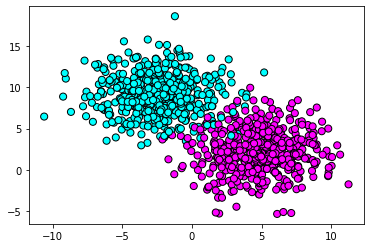

In [2]:
X, y = generate_blob_cluster()

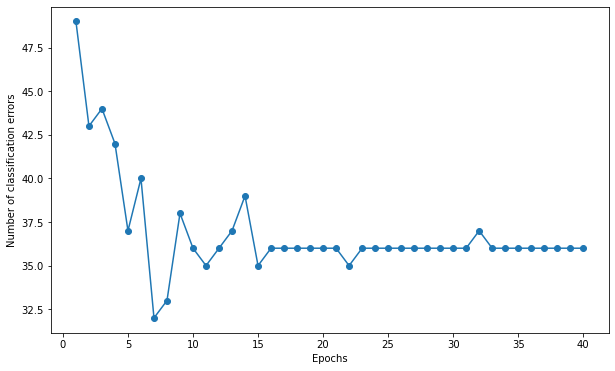

In [88]:
ppn = Perceptron(n_iter=40, learning_rate=10)

ppn.fit(X, y)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker="o")
plt.xlabel("Epochs")
plt.ylabel("Number of classification errors")
# plt.savefig('images/02_07.png', dpi=300)
plt.show()

As we can see in Figure above, our perceptron converged after certain epoch and should now be able
to classify the training examples perfectly.


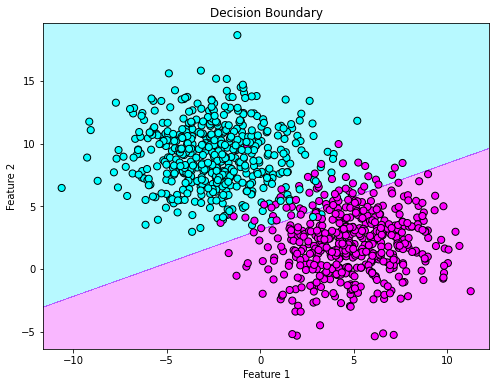

In [6]:
plot_decision_regions(X, y, classifier=ppn)

Notice that the initial weight vector contains small random numbers drawn from a normal distribution
with a standard deviation of `0.01` via `rgen.normal`.

Technically, we could initialize the weights to `zero` . However, if we did that, then the learning rate would have no effect on the decision boundary. If all the weights are initialized to `zero`, t**he learning rate parameter, affects only the scale of the weight vector, not the direction**.


In [8]:
def update_weights(
    w,
    input_vector,
    lr=0.1,
):
    dw_ = lr * input_vector
    return w + dw_


def calculate_angle(w, input_vector):
    dot_product = np.dot(w, input_vector)
    norm_w = np.linalg.norm(w)
    norm_input = np.linalg.norm(input_vector)
    """
    np.arccos is the trigonometric inverse cosine, and np.linalg.norm is a function that computes
    the length of a vector.
    """
    return np.degrees(np.arccos(dot_product / (norm_w * norm_input)))


w_zero = np.array([0, 0, 0])
w_norm = np.array([-0.00165135, -0.01933613, 0.00012572])
input_vector = np.array([1, 2, 3])

print(calculate_angle(update_weights(w_zero, input_vector, lr=0.1), input_vector))
print(calculate_angle(update_weights(w_zero, input_vector, lr=0.01), input_vector))
print(calculate_angle(update_weights(w_norm, input_vector, lr=0.1), input_vector))
print(calculate_angle(update_weights(w_norm, input_vector, lr=0.01), input_vector))

0.0
0.0
2.552882324525421
31.218586527045833


We can see that the angle between `input_vector` and `w_updated` is exactly zero.


## Adaptive linear neurons and the convergence of learning


The **Adaline** algorithm is particularly interesting because it illustrates the key concepts of defining and
minimizing **continuous loss functions**.

The key difference between the Adaline rule (also known as the Widrow-Hoff rule) and Rosenblatt’s
perceptron is that the **weights are updated based on a linear activation function rather than a unit step
function like in the perceptron**. In Adaline, the **linear activation function, $\sigma(z)$,** is simply the identity function of the net input, so that $\sigma(z) = z$. _While the linear activation function is used for learning the weights, we still use a threshold function to make the final prediction._


### Minimizing loss functions with gradient descent


#### Introduction to gradient


In calculus, the **gradient** represents the **rate of change or the slope of a function at a particular point in a multi-dimensional space**. In general terms, **A `gradient` is a vector** that **consists of partial derivatives of a function with respect to each of its variables. A partial derivative measures how a function changes with respect to one of its variables, while the gradient encompasses all the partial derivatives to represent the function's overall rate of change in multiple directions. It's a **vector that points in the direction of the steepest ascent(`moving up`) of a function at a given point**.**

The gradient of a function $f$ in multi-dimensional space is denoted by $\nabla f$ and represented as:

$$
\nabla f = \frac{\partial f}{\partial x_1} \mathbf{i} + \frac{\partial f}{\partial x_2} \mathbf{j} + \ldots + \frac{\partial f}{\partial x_n} \mathbf{k}
$$

This equation showcases how the gradient is composed of partial derivatives with respect to each variable $ x_1, x_2, \ldots, x_n $ multiplied by their respective unit vectors $ \mathbf{i}, \mathbf{j}, \mathbf{k} $ in three dimensions. Vector Notation:

$$
\nabla f = \begin{bmatrix}
\frac{\partial f}{\partial x_1} \\
\frac{\partial f}{\partial x_2} \\
\vdots \\
\frac{\partial f}{\partial x_n}
\end{bmatrix}
$$

Lets, consider a function $f(x) = x^2$ and its gradient $\nabla f(x) = 2x$, for better understanding


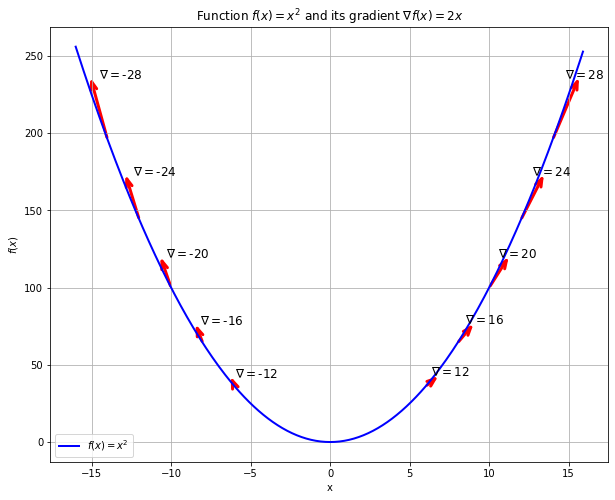

In [2]:
plot_gradient_one_var()

As illustrated in the figure, geometrically, **the direction of the gradient indicates the direction in which the function increases most rapidly, while the magnitude of the gradient represents the steepness of the slope.**

For the provided function $f(x) = x^2$, when $x = -6$, the corresponding $f(x)$ value is $36$, and the gradient $\nabla f(x)$ is $-12$. Moving $-12$ units in the $x$ direction (or, $x = x + \nabla f(x) = -18$),meaning in the direction of the gradient, will result in the greatest increase in the function value ($f(-18) = 324$).

Importantly, the magnitude of change varies with the magnitude of $x$, showcasing how the gradient captures both direction and steepness in relation to the function's input.


#### (Full batch) gradient descent


In the case of **Adaline**, we can define the loss function, $L$, to learn the model parameters as the **mean squared error (MSE)** between the calculated outcome and the true class label:

$$
L(\mathbf{w},b) = \frac{1}{2n} \sum_{i=1}^{n} \left(y^{(i)} - \sigma(\mathbf{w}^\top \mathbf{x}^{(i)}+\mathbf{b}^{(i)})\right)^2, or
$$

$$
L(\mathbf{w},b) = \frac{1}{2n} \sum_{i=1}^{n} \left(y^{(i)} - \sigma({z}^{(i)})\right)^2
$$

The term $1/2$ is just added for our convenience and will make it easier to derive the gradient of the loss function with respect to the weight parameters. The main advantage of this continuous linear activation function, in contrast to the unit step function, is that the loss function becomes differentiable. Another nice property of this loss function is that it is convex; thus, we can use a very simple yet powerful optimization algorithm called **gradient descent** to find the weights that minimize our loss function.

**In contrast to the prior scenario where moving in the direction of the gradient ($x = x + \nabla f(x)$) maximized the function, minimizing the loss involves moving in the opposite direction of the gradient ($x = x - \nabla f(x)$ or, equivalently, $w = w - \nabla L(w)$). This adjustment, dictated by the learning rate and the gradient's steepness ($w = w - \eta\nabla L(w)$, $b = b - \eta\nabla L(b)$), steers the parameter updates toward minimizing the loss function.**


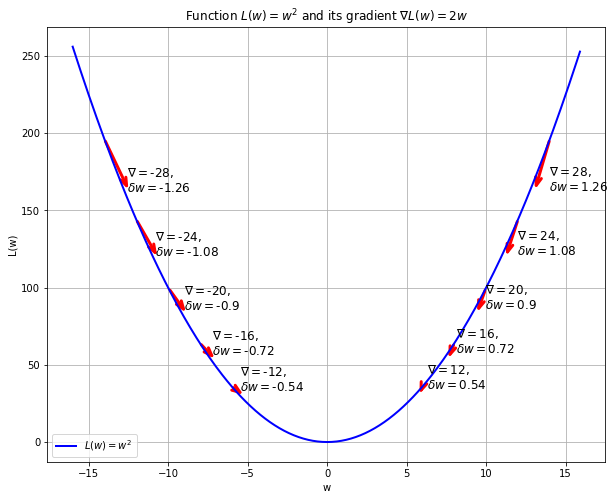

In [3]:
plot_gradient_descent_one_var()

<p align="center">
<img src="img/gd.jpg" alt="gd.jpg" width="500px"/>
</p>

In terms of gradient descent for the above given function $L(w) = w^2$, at $w = -6$, the corresponding loss $L(w)$ is $36$, and the gradient $\nabla L(w)$ is $-12$. To minimize the loss $L(w)$, we move opposite to the gradient, that is, updating $w$ as $w = w + (- \eta \cdot \text{grad})$ or $w = -6 +(- 0.1 \cdot (-12)) = -6 + 1.2 = -4.8$. This new value of $w$ results in a reduced loss, $L(w) = (-4.8)^2 = 23$, which is lower than the previous loss of $36$.

Therefore, the changes in parameters, $\Delta w$ and $\Delta b$, aiming to minimize the loss function $L(w)$, are defined as the negative gradient multiplied by the learning rate, $\eta$:

$$
\Delta w = -\eta \cdot \nabla L(w)
$$

$$
\Delta b = -\eta \cdot \nabla L(b)
$$

Here, $\nabla L(w)$ represents the gradient of the loss function $L$ with respect to the weight $w$, and $\nabla L(b)$ denotes the gradient of $L$ with respect to the bias $b$. These updates, scaled by the learning rate $\eta$, guide the parameter adjustments during the training process using gradient descent.

To compute the gradient of the loss function, we need to compute the partial derivative of the loss
function with respect to each weight, $w_j$:

$$
\frac{\partial L}{\partial w_j} = -\frac{2}{n} \sum_{i=1}^{n} (y^{(i)} - \sigma(z^{(i)}))x_j^{(i)}
$$

Similarly, we compute the partial derivative of the loss with respect to the bias as:

$$
\frac{\partial L}{\partial b} = -\frac{2}{n} \sum_{i=1}^{n} (y^{(i)} - \sigma(z^{(i)}))
$$

So we can write the weight update as:

$
\Delta w_j = -\eta \frac{\partial L}{\partial w_j}
$
and
$
\Delta b = -\eta \frac{\partial L}{\partial b}
$

Simultaneous Update (Adaline Learning Rule):

$$
\begin{align*}
w_j &\leftarrow w_j + \Delta w_j  \\
b &\leftarrow b + \Delta b
\end{align*}
$$

Furthermore, the weight update is calculated based on all examples in the training dataset (instead of updating the parameters incrementally after each training example), which is why this approach is also referred to as **batch gradient descent** or **full batch gradient descent**.


In [7]:
class AdalineGD:
    """ADAptive LInear NEuron classifier.
    Parameters
    ------------
    learning_rate : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.
    random_state : int
        Random number generator seed for random weight initialization.
    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    b_ : Scalar
        Bias unit after fitting.
    losses_ : list
        Mean squared error loss function values in each epoch.
    """

    def __init__(self, learning_rate=0.01, n_iter=50, random_state=1):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.
        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
        Training vectors, where n_examples
        is the number of examples and
        n_features is the number of features.
        y : array-like, shape = [n_examples]
        Target values.
        Returns
        -------
        self : object
        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float_(0.0)
        self.losses_ = []
        # implement full batch gradient descent
        for _ in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = y - output
            # ∂L/∂w = -(2/n)Σ(yi-σ(zi))xi
            pd_loss__pd_w = -2 * np.dot(X.T, errors) / X.shape[0]
            # Δw=−η⋅∂L/∂w
            dw = -self.learning_rate * pd_loss__pd_w
            # w = w + Δw
            self.w_ += dw
            # ∂L/∂b = -(2/n)Σ(yi-σ(zi))
            pd_loss__pd_b = -2 * np.sum(errors) / X.shape[0]
            # Δb=−η⋅∂L/∂b
            db = -self.learning_rate * pd_loss__pd_b
            # b = b + Δb
            self.b_ += db
            # in short:
            # self.w_ += self.learning_rate * 2.0 * X.T.dot(errors) / X.shape[0]
            # self.b_ += self.learning_rate * 2.0 * errors.mean()
            loss = np.mean(errors**2)
            self.losses_.append(loss)

        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """Compute linear activation"""
        return X

    # for classifying
    def predict(self, X, th=0.5):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= th, 1, 0)

Instead of updating the weights after evaluating each individual training example, as in the perceptron,
we calculate the gradient based on the whole training dataset.

**Please note that the activation method has no effect on the code since it is simply an identity function**.Here, we added the activation function (computed via the activation method) to illustrate the general concept with regard to how information flows through a single-layer NN: features from the input data, net input, activation, and output.


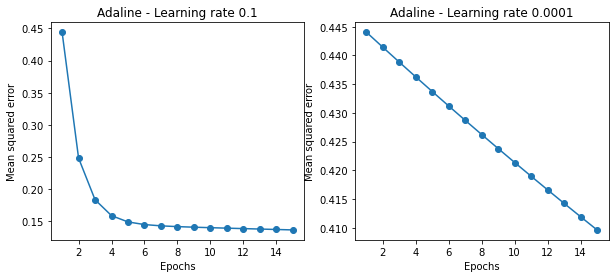

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ada1 = AdalineGD(n_iter=15, learning_rate=0.01).fit(X, y)
ax[0].plot(range(1, len(ada1.losses_) + 1), ada1.losses_, marker="o")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Mean squared error")
ax[0].set_title("Adaline - Learning rate 0.1")

ada2 = AdalineGD(n_iter=15, learning_rate=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.losses_) + 1), ada2.losses_, marker="o")


ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Mean squared error")
ax[1].set_title("Adaline - Learning rate 0.0001")
plt.show()

we can see that the loss decreases on the right plot, but the chosen learning rate, `𝜂=0001` , is so small that the algorithm would require a very large number of epochs to converge to the global loss minimum


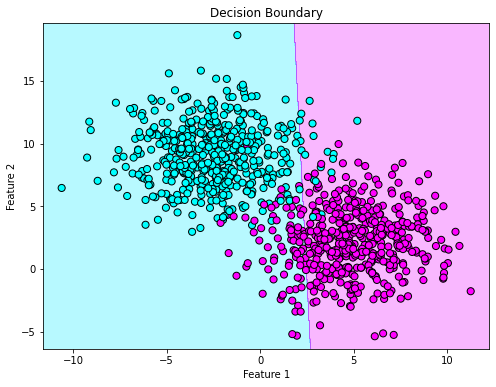

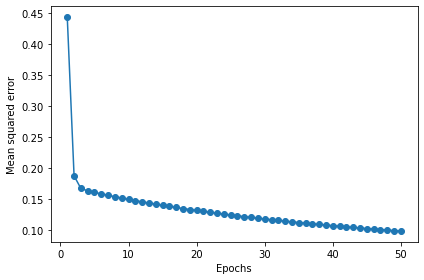

In [37]:
ada_gd = AdalineGD(n_iter=50, learning_rate=0.019)
ada_gd.fit(X, y)
plot_decision_regions(X=X, y=y, classifier=ada_gd)
plt.plot(range(1, len(ada_gd.losses_) + 1), ada_gd.losses_, marker="o")
plt.xlabel("Epochs")
plt.ylabel("Mean squared error")
plt.tight_layout()
plt.show()

#### Mini batch gradient descent


Large-scale machine learning and stochastic gradient descent


In the previous section, we learned how to minimize a loss function by taking a step in the opposite
direction of the loss gradient that is calculated from the whole training dataset; this is why this approach
is sometimes also referred to as full batch gradient descent. Now imagine that we have a very large
dataset with millions of data points, which is not uncommon in many machine learning applications.
Running full batch gradient descent can be computationally quite costly in such scenarios, since we
need to reevaluate the whole training dataset each time we take one step toward the global minimum.


A popular alternative to the **batch gradient descent** algorithm is **stochastic gradient descent (SGD)**,
which is sometimes also called iterative or online gradient descent. Instead of updating the weights
based on the **sum of the accumulated errors over all training examples**, $x^{(i)}$:

$$
\Delta w_j = \frac{2\eta}{n} \sum_{i=1}^{n} (y^{(i)} - \sigma(z^{(i)})) \cdot x^{(i)}_j
$$

**we update the parameters incrementally for `each` training example**, for instance:

$$
\Delta w_j = \eta \cdot (y^{(i)} - \sigma(z^{(i)})) \cdot x^{(i)}_j
$$

$$
\Delta b = \eta \cdot (y^{(i)} - \sigma(z^{(i)}))
$$

Although `SGD` can be considered as an _approximation of gradient descent, it typically reaches convergence much faster because of the more frequent weight updates._ Since each gradient is calculated
based on a single training example, the error surface is noisier than in gradient descent, which can
also have the advantage that SGD can escape shallow local minima more readily if we are working
with nonlinear loss functions.

_To obtain satisfying results via SGD, it is important to present training data in a random order; also, we want to shuffle the training dataset for every epoch to prevent cycles._

Another advantage of SGD is that we can use it for online learning. In online learning, our model is
trained on the fly as new training data arrives. This

**Mini-batch gradient descent** is a compromise between **full batch gradient descent and stochastic gradient descent (SGD)**. It involves applying full batch gradient descent to smaller subsets of the training data, such as 32 examples at a time. This approach accelerates convergence by enabling more frequent weight updates. Additionally, mini-batch learning allows for efficient vectorized operations, allowing us to replace the `for` loop over the training examples in SGD.


Code implementation:

Inside the `fit` method, we will now update the weights after each training example. Furthermore, we will implement an additional `partial_fit` method, which does not reinitialize the weights, for online learning. In order to check whether our algorithm converged after training, we will calculate the loss as the average loss of the training examples in each epoch. Furthermore, we will add an option to shuffle the training data before each epoch to avoid repetitive cycles when we are optimizing the loss function; via the random_state parameter, we allow the specification of a random seed for reproducibility:


In [47]:
class AdalineGD:
    """ADAptive LInear NEuron classifier.
    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent cycles.
    random_state : int
        Random number generator seed for random weight initialization.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    b_ : Scalar
        Bias unit after fitting.
    losses_ : list
        Mean squared error loss function values in each epoch.
    """

    def __init__(self, learning_rate=0.01, n_iter=10, shuffle=True, random_state=69):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.
        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
            Training vectors, where n_examples is the number of examples and n_features is the number of features.
        y : array-like, shape = [n_examples]
            Target values.
        Returns
        -------
        self : object
        """
        self._initialize_weights(X.shape[1])
        self.losses_ = []
        for _ in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            losses = []
            for xi, target in zip(X, y):
                losses.append(self._update_weights(xi, target))
            avg_loss = np.mean(losses)
            self.losses_.append(avg_loss)
        return self

    def partial_fit(self, X, y):
        """Fit training data without re-initializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]

    def _initialize_weights(self, m):
        """Initialize weights to small random numbers"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=m)
        self.b_ = np.float_(0.0)
        self.w_initialized = True

    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(self.net_input(xi))
        error = target - output
        pd_loss__pd_w = 2.0 * xi * (error)
        dw = self.learning_rate * pd_loss__pd_w
        self.w_ += dw
        pd_loss__pd_b = 2.0 * (error)
        db = self.learning_rate * pd_loss__pd_b
        self.b_ += db
        loss = error**2
        return loss

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """Compute linear activation"""
        return X

    # for classifying
    def predict(self, X, th=0.5):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= th, 1, 0)

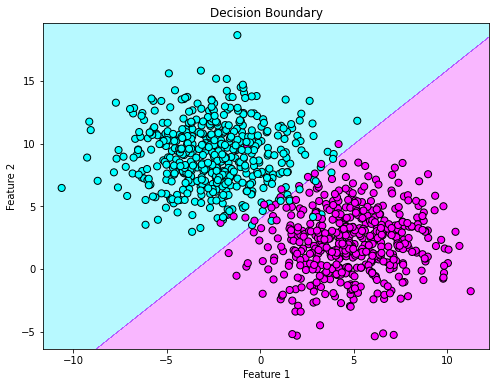

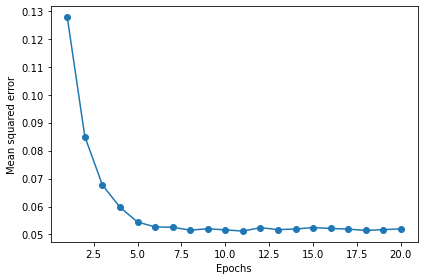

In [78]:
ada_gd = AdalineGD(n_iter=20, learning_rate=0.001)
ada_gd.fit(X, y)
plot_decision_regions(X=X, y=y, classifier=ada_gd)
plt.plot(range(1, len(ada_gd.losses_) + 1), ada_gd.losses_, marker="o")
plt.xlabel("Epochs")
plt.ylabel("Mean squared error")
plt.tight_layout()
plt.show()

If we want to update our model, for example, in an online learning scenario with streaming data, we could simply call the partial_fit method on individual training examples—for instance, `ada_sgd.partial_fit(X_new(i), y(i)).`


(1000, 2) (1000,)


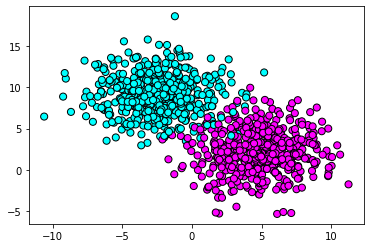

(1000, 2) (1000,)


In [48]:
online_data_X, online_data_y = generate_blob_cluster()
print(online_data_X.shape, online_data_y.shape)

In [80]:
print(ada_gd.w_)

ada_gd.partial_fit(online_data_X[0, :], online_data_y[0])

print(ada_gd.w_)

[ 0.06636402 -0.05597241]
[ 0.06665753 -0.06029854]


## Multilayer neural network


### Recap single neural network


In every epoch (pass over the training dataset), we updated the weight vector $w$ and bias unit $b$ using the following update rule:

$$
\Delta w_j = -\eta \frac{\partial \mathcal{L}}{\partial w_j}
$$

and

$$
\Delta b = -\eta \frac{\partial \mathcal{L}}{\partial b}
$$

where $\Delta w_j$ is the change in weight $w_j$, $\eta$ is the learning rate, and $\frac{\partial \mathcal{L}}{\partial w_j}$ and $\frac{\partial \mathcal{L}}{\partial b}$ represent the partial derivatives for the bias unit and each weight $w_j$ in the weight vector $w$.

In other words, we computed the gradient based on the whole training dataset and updated the weights of the model by taking a step in the opposite direction of the loss gradient $\nabla \mathcal{L}(\mathbf{w})$.

In gradient descent optimization, we updated all weights simultaneously after each epoch, and we defined the partial derivative for each weight $w_j$ in the weight vector $w$ as follows:

$$
\frac{\partial \mathcal{L}}{\partial w_j} = -\frac{1}{n} \sum_{i=1}^{n} (y^{(i)} - a^{(i)})x_j^{(i)} = -\frac{1}{n} \sum_{i=1}^{n} (y^{(i)} - a^{(i)})x_j^{(i)}
$$

Here, $y^{(i)}$ is the target class label of a particular sample $x^{(i)}$, and $a^{(i)}$ is the activation of the neuron, which is a linear function in the special case of Adaline.

Furthermore, we defined the activation function $\sigma(\cdot)$ as follows:

$$
\sigma(\cdot) = \mathbf{z} = \sum_{j} w_j x_j + b = \mathbf{w}^T \mathbf{x} + b
$$

While we used the activation $\sigma(\cdot)$ to compute the gradient update, we implemented a threshold function to squash the continuous-valued output into binary class labels for prediction:

$$
\widehat{y} =
\begin{cases}
1 & \text{if } \mathbf{z} \geq 0 \\
0 & \text{otherwise}
\end{cases}
$$

Also, we learned about a certain trick to accelerate the model learning, the so-called stochastic gradient
descent (SGD) optimization. SGD approximates the loss from a single training sample (online
learning) or a small subset of training examples (mini-batch learning). We will make use of this concept
later in this chapter when we implement and train a multilayer perceptron (MLP)


### Introducing the multilayer neural network


<p align="center">
<img src="img/mlp.jpg" alt="mlp.jpg" width="500px"/>
</p>

**_Adding additional hidden layers_**:

We can add any number of hidden layers to the MLP to create deeper network architectures. Practically, **we can think of the number of layers and units in an NN as additional `hyperparameters`** that we want to optimize for a given problem task using the cross-validation technique.

However, the loss gradients for updating the network’s parameters, which we will calculate later via **backpropagation**, will become increasingly small as more layers are added to a network. This **vanishing gradient** problem makes model learning more challenging. Therefore, special algorithms have been developed to help train such DNN structures; this is known as **deep learning**,


As shown in the above figure, we denote the $i$ th activation unit in the $l$ th layer as $a^{(l)}_i$. To make the math and code implementations more intuitive, we will not use numerical indices to refer to layers. Instead, we will use the superscripts: $^{in}$ for the input features, $^{h}$ for the hidden layer, and $^{out}$ for the output layer.

For instance:

- $x^{(in)}_i$ refers to the $i$ th input **feature value** (not $i$ example).
- $a^{(h)}_i$ refers to the $i$ th unit in the hidden layer.
- $a^{(out)}_i$ refers to the $i$ th unit in the output layer.

Note that the $b$’s denote the bias units. In fact, $b^{(h)}$ and $b^{(out)}$ are vectors with the number of elements equal to the number of nodes in the corresponding layer. For example, $b^{(h)}$ stores $d$ bias units, where $d$ is the number of nodes in the hidden layer.


Each node in layer $l$ is connected to all nodes in layer $l + 1$ via a weight coefficient. For instance, the connection between the $k$ th unit in layer $l$ to the $j$ th unit in layer $l + 1$ will be represented as $w_{jk}^{(l)}$, in short, $w_{j}^{(l)}$.

Referring back to figure we denote the weight matrix that connects the input to the hidden layer as $W^{(h)}$, and we represent the matrix connecting the hidden layer to the output layer as $W^{(out)}$.


First, let’s summarize the MLP learning procedure in three simple steps:

1. Starting at the input layer, we **forward propagate** the patterns of the training data through the network to generate an output.
2. Based on the network’s output, we **calculate the loss** that we want to minimize using a loss
   function that we will describe later.
3. We **backpropagate** the loss, find its derivative with respect to each weight and bias unit in the
   network, and update the model.

Now, let’s walk through the individual steps of forward propagation to generate an output from the patterns in the training data. Since each unit in the hidden layer is connected to all units in the input layers, we first calculate the activation unit of the hidden layer $a^{(h)}_1$ as follows:

$$
z_1^{(h)} = x_1^{(in)} w_{1,1}^{(h)} + x_2^{(in)} w_{1,2}^{(h)} + \dots + x_m^{(in)} w_{1,m}^{(h)}
$$

$$
a_1^{(h)} = \sigma(z_1^{(h)})
$$

Here, $z_1^{(h)}$ represents the net input, and $\sigma(\cdot)$ is the activation function, crucial for differentiable learning of weights connecting neurons. For solving complex problems like image classification, nonlinear activation functions, such as the sigmoid (logistic) function, are required:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$


For purposes of code efficiency and readability, we can represent the activation more succinctly using linear algebra concepts, allowing for vectorized implementations via NumPy instead of multiple nested Python for loops:

$$
z^{(h)} = x^{(in)}W^{(h)T} + b^{(h)}
$$

$$
a^{(h)} = \sigma(z^{(h)})
$$

Here, $x^{(h)}$ is our $\bf 1 \times  m$ dimensional **feature vector**. $W^{(h)}$ is a $\bf d \times m$ dimensional weight matrix **where $d$ is the number of units in the hidden layer**. Consequently, the transposed matrix $W^{(h)T}$ is $\bf m \times d$ dimensional. The bias vector $b^{(h)}$ consists of $d$ bias units (one bias unit per hidden node). After matrix-vector multiplication, we obtain the $\bf 1 \times d$ dimensional net input vector $z^{(h)}$ to calculate the activation $a^{(h)}$ (where $a^{(h)} \in \mathbb{R}^{1 \times d}$).


In [3]:
npr = np.random.RandomState(1)


def Sigmoid(x):
    return 1 / (1 + np.exp(-x))


n_examples = 1
n_features = 28 * 28  # image
n_hidden = 100

x = npr.randn(n_examples, n_features)
print(x.shape)
Wh = npr.normal(size=(n_hidden, n_features), scale=0.1)
bh = np.zeros((n_hidden,))

zh = x @ Wh.T + bh
ah = Sigmoid(zh)
ah.shape, ah.shape[1] == n_hidden

(1, 784)


((1, 100), True)

Furthermore, we generalize this computation to all $n$ examples in the training dataset:

$$
Z^{(h)} = X^{(in)}W^{(h)T} + b^{(h)}
$$

Here, $X^{(in)}$ is now an $\bf n \times m$ matrix, and the matrix multiplication will result in an $\bf n \times d$ dimensional net input matrix $Z^{(h)}$. Finally, we apply the activation function $\sigma(\cdot)$ to each value in the net input matrix to get the $n \times d$ activation matrix in the next layer (here, the output layer):

$$
A^{(h)} = \sigma(Z^{(h)})
$$


In [57]:
n_examples = 1000
n_features = 28 * 28  # image
n_hidden = 100

X = npr.randn(n_examples, n_features)
print(x.shape)
Wh = npr.normal(size=(n_hidden, n_features), scale=0.1)
bh = np.zeros((n_hidden,))

Zh = X @ Wh.T + bh
Ah = Sigmoid(Zh)
Ah.shape, Ah.shape[1] == n_hidden

(1000, 784)


((1000, 100), True)

Finally, we represent the activation of the **output layer** in vectorized form for multiple examples:

$$
Z^{(out)} = A^{(h)}W^{(out)T} + b^{(out)}
$$

Here, we multiply the transpose of the $\bf t \times d$ matrix $W^{(out)}$ (**$t$ is the number of output units**) by the $\bf n \times d$ dimensional matrix $A^{(h)}$ and add the $t$ dimensional bias vector $b^{(out)}$ to obtain the $\bf n \times t$ dimensional matrix $Z^{(out)}$. (The columns in this matrix represent the outputs for each sample.)

Lastly, we apply the sigmoid activation function to obtain the continuous-valued output of our network:

$$
A^{(out)} = \sigma(Z^{(out)})
$$

Similar to $Z^{(out)}$, $A^{(out)}$ is an $\bf n \times t$ dimensional matrix.


In [59]:
n_classes = 2

Wo = npr.normal(size=(n_classes, n_hidden), scale=0.1)
bo = np.zeros((n_classes,))

Zo = Ah @ Wo.T + bo
Ao = Sigmoid(Zo)
Ao.shape, Ao.shape[1] == n_classes

((1000, 2), True)

Heres the entire flow:

<p align="center">
<img src="img/simple_nn.jpg" alt="simple_nn.jpg" width="1000px"/>
</p>


**Adding more layer and using reusable layer like in Pytorch/Tensorflow implementation:**


<p align="center">
<img src="img/sequential.png" alt="sequential.png" width="400px"/>
</p>


Coding intuition for `nn.Linear`:

<p align="center">
<img src="img/linear_code.jpg" alt="linear_code.jpg" width="800px"/>
</p>


In [4]:
class Linear:
    def __init__(self, in_features, out_features, random_seed=1):
        npr = np.random.RandomState(random_seed)
        self.in_features = in_features
        self.out_features = out_features
        self.weight = npr.normal(size=(out_features, in_features), scale=0.1)
        self.bias = np.zeros((out_features,))

    def forward(self, X):
        return X @ self.weight.T + self.bias

Defining more reusable comp.


In [169]:
class ReLU:
    def forward(self, X):
        return np.maximum(0, X)


class Sigmoid:
    def forward(self, X):
        return 1 / (1 + np.exp(-X))


class Sequential:
    def __init__(self, layers):
        self.layers = layers
        self.outputs = []  # Store outputs of each layer

    def __call__(self, X):
        self.outputs = []  # Reset outputs for each forward pass
        for layer in self.layers:
            X = layer.forward(X)
            self.outputs.append(X.copy())  # Store the output of each layer
        return X

(1000, 2) (1000,)


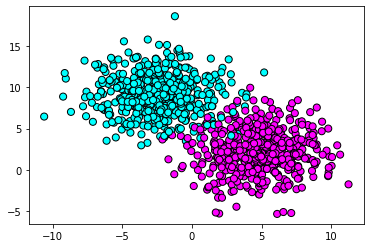

In [6]:
X_train, X_test, y_train, y_test = generate_blob_cluster(split_train_test=True)

In [7]:
n_classes = 2
model = Sequential(
    [
        Linear(2, 10),  # 0: Layer 1 net input :Z1
        Sigmoid(),  # 1: Layer 1 activation :A1
        Linear(10, n_classes),  # 2: Layer 2/Output layer net input :Zo
        Sigmoid(),  # 3: Layer 2/Output layer activation :Ao
    ]
)


# pred = model(X)
# np.where(pred >= 0.5, 1, 0)[:, 0]
probas = model(X_test)
print(probas[:2])
predicted_labels = np.argmax(probas, axis=1)
print(predicted_labels[:10])
onehot_targets = int_to_onehot(y_test, num_labels=2)
loss = np.mean((onehot_targets - probas) ** 2)
correct_pred = (predicted_labels == y_test).sum()
acc = correct_pred / X_test.shape[0]
print(loss, acc)

[[0.46725763 0.48185718]
 [0.51270125 0.50086963]]
[1 0 0 1 0 0 0 0 0 0]
0.24646401678734076 0.8515151515151516


In [8]:
mse, acc = compute_mse_and_acc(model, X_test, y_test)
print(f"Initial valid MSE: {mse:.1f}")
print(f"Initial valid accuracy: {acc*100:.1f}%")

Initial valid MSE: 0.4
Initial valid accuracy: 85.7%


### Introduction to Basic BackPropagation


- [https://ml-cheatsheet.readthedocs.io/en/latest/backpropagation.html](https://ml-cheatsheet.readthedocs.io/en/latest/backpropagation.html)
- [https://www.jeremyjordan.me/neural-networks-training/](https://www.jeremyjordan.me/neural-networks-training/)


How do we updates the weights of a MLP?

We start by performing forward propagation to calculate the activation of the output layer, formulated as:

$$Z_{1} = XW^{T}_{1}+ b_{1} \quad \text{(net input of the hidden layer 1)}$$

$$A_{1} = \sigma(Z_{1}) \quad \text{(activation of the hidden layer 1)}$$

$$Z_{(out)} = A_{1}W_{(out)}^{T} + b_{(out)} \quad \text{(net input of the output layer)}$$

$$A_{(out)} = \sigma(Z_{(out)}) \quad \text{(activation of the output layer)}$$

And, Mean Squared Error (MSE) loss function encompasses both averaging over the $t$ activation units in the network and averaging over the $n$ examples in the dataset or mini-batch:

$$L(W) = \frac{1}{n} \sum_{i=1}^{n} \frac{1}{t} \sum_{j=1}^{t} (Y_j^{(i)} - A_{j}^{(out)(i)})^2$$

Here, the superscript $[i]$ refers to a specific example in our training dataset.

Our objective is to minimize the loss function $L(W)$, hence we need to compute the partial derivatives of the parameters $W$ concerning each weight for every layer in the network.

$$\frac{\partial L}{\partial W_{1}} = ?$$

$$\frac{\partial L}{\partial W_{out}} = ?$$

and then udate the corresponding weights:

$$W_1 \leftarrow W_1 - \eta \frac{\partial L}{\partial W_{1}}$$
$$W_{out} \leftarrow W_{out} - \eta \frac{\partial L}{\partial W_{out}}$$

<p align="center">
<img src="img/forward.jpg" alt="forward.jpg" width="800px"/>
</p>

As a reminder, the chain rule states:

$$\frac{\partial}{\partial Z} p(q((z))) = \frac{\partial p}{\partial q}\frac{\partial q}{\partial Z}$$

Let's apply the chain rule to solve for **The Gradient for output layer is given by**:

$$\frac{\partial L}{\partial W_{out}} = (\frac{\partial L}{\partial A_{out}} \times \frac{\partial A_{out}}{\partial Z_{out}}) \times \frac{\partial Z_{out}}{\partial W_{out}}=\delta_{out}\times \frac{\partial Z_{out}}{\partial W_{out}}$$

This is because $\delta_{out}$ terms are involved in computing the partial derivatives (or gradients) of the
hidden layer weights as well; hence, we can reuse $\delta_{out}$ .

And derivatives of each terms are:

$$
\frac{\partial L}{\partial A_{out}}  =  \frac{\partial}{\partial A_{out}}(y-A_{out})^{2} = 2(A_{out}-y)
$$

$$
\frac{\partial A_{out}}{\partial Z_{out}}  =  \frac{\partial}{\partial Z_{out}}(\frac{1}{1+e^{Z_{out}}}) = (\frac{1}{1+e^{Z_{out}}}) (1- \frac{1}{1+e^{Z_{out}}}) = A_{out}(1-A_{out})
$$

$$
\frac{\partial Z_{out}}{\partial W_{out}}  =  \frac{\partial}{\partial W_{out}}(A_{1}W_{(out)}^{T}+b_{(out)}) = A_{1}
$$


By similar logic, we can find **The Gradient for hidden layer 1 is given by**:

$$
\frac{\partial L}{\partial W_{1}} = (\frac{\partial L}{\partial A_{out}} \times \frac{\partial A_{out}}{\partial Z_{out}})\times \frac{\partial Z_{out}}{\partial A_{1}} \times \frac{\partial A_{1}}{\partial Z_{1}} \times \frac{\partial Z_{1}}{\partial W_{1}}
$$

$$
= (\delta_{out}) \times \frac{\partial Z_{out}}{\partial A_{1}} \times \frac{\partial A_{1}}{\partial Z_{1}} \times \frac{\partial Z_{1}}{\partial W_{1}}
$$

$$
= \frac{\partial L}{\partial A_{1}} \times \frac{\partial A_{1}}{\partial Z_{1}} \times \frac{\partial Z_{1}}{\partial W_{1}}
$$

Where the derivatives of each terms are:

$$
\frac{\partial L}{\partial A_{1}} = (\delta_{out}) \times \frac{\partial Z_{out}}{\partial A_{1}} = (\frac{\partial L}{\partial A_{out}} \times \frac{\partial A_{out}}{\partial Z_{out}})\times \frac{\partial Z_{out}}{\partial A_{1}}
$$

$$
\frac{\partial Z_{out}}{\partial A_{1}} = \frac{\partial}{\partial A_{1}}(A_{1}W_{(out)} + b_{(out)}) = W_{(out)}
$$

$$
\frac{\partial A_{1}}{\partial Z_{1}}= A_{1}(1-A_{1})
$$

$$
\frac{\partial Z_{1}}{\partial W_{1}} = \frac{\partial}{\partial W_{1}}(XW_{(1)} + b_{(1)}) = X
$$

<p align="center">
<img src="img/backward.jpg" alt="backward.jpg" width="800px"/>
</p>


In [140]:
def backward_weight_update(model, X, y, learning_rate=0.1):
    #### Compute outputs ####
    Ao = model(X)
    A1 = model.outputs[1]
    Wo = model.layers[2].weight

    # Convert integer labels 'y' to one-hot encoded format
    onehot_targets = int_to_onehot(y, num_labels=2)

    # Calculate error (assuming mean squared error)
    error = Ao - onehot_targets

    # gradient for output layer
    d_loss_dA_out = 2 * (error) / y.shape[0]
    dA_out_dZ_out = Ao * (1 - Ao)  # Derivative of sigmoid
    delta_out = d_loss_dA_out * dA_out_dZ_out  # error

    dZ_out_dW_out = A1  # =`A1` # input

    d_loss_dW_out = np.dot(delta_out.T, dZ_out_dW_out)  # loss=error*input
    d_loss_db_out = np.sum(delta_out, axis=0)

    # gradient for hidden layer 1
    d_z_out__a_1 = Wo
    d_loss__a_1 = np.dot(delta_out, d_z_out__a_1)
    d_a_1__d_z_1 = A1 * (1.0 - A1)  # sigmoid derivative
    delta_1 = d_loss__a_1 * d_a_1__d_z_1  # error

    d_z_1__d_w_1 = X  # input

    d_loss__d_w_1 = np.dot(delta_1.T, d_z_1__d_w_1)  # loss=error*input
    d_loss__d_b_1 = np.sum((d_loss__a_1 * d_a_1__d_z_1), axis=0)

    # Update weights
    model.layers[0].weight -= learning_rate * d_loss__d_w_1
    model.layers[0].bias -= learning_rate * d_loss__d_b_1
    model.layers[2].weight -= learning_rate * d_loss_dW_out
    model.layers[2].bias -= learning_rate * d_loss_db_out

    return model

Epoch: 001/050 | Train MSE: 0.28 | Train Acc: 83.67% | Valid Acc: 85.33%
Epoch: 011/050 | Train MSE: 0.15 | Train Acc: 96.33% | Valid Acc: 97.67%
Epoch: 021/050 | Train MSE: 0.08 | Train Acc: 96.50% | Valid Acc: 97.67%
Epoch: 031/050 | Train MSE: 0.06 | Train Acc: 96.67% | Valid Acc: 97.67%


Epoch: 041/050 | Train MSE: 0.05 | Train Acc: 96.17% | Valid Acc: 98.00%


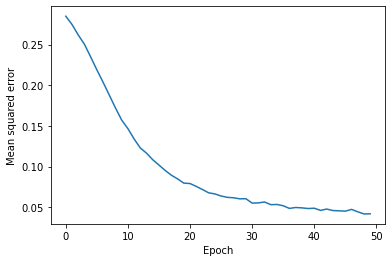

In [141]:
num_epochs = 50  # Number of training epochs
epoch_loss = []
epoch_train_acc = []
epoch_valid_acc = []
model = Sequential(
    [
        Linear(2, 10),  # 0: Layer 1 net input :Z1
        Sigmoid(),  # 1: Layer 1 activation :A1
        Linear(10, n_classes),  # 2: Layer 2/Output layer net input :Zo
        Sigmoid(),  # 3: Layer 2/Output layer activation :Ao
    ]
)
for epoch in range(num_epochs):
    # Forward and backward passes with weight update
    # iterate over minibatches
    minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size=100)

    for X_mini, y_mini in minibatch_gen:
        model = backward_weight_update(model, X_mini, y_mini, learning_rate=0.1)
    #### Epoch Logging ####
    train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
    valid_mse, valid_acc = compute_mse_and_acc(model, X_test, y_test)
    train_acc, valid_acc = train_acc * 100, valid_acc * 100
    epoch_train_acc.append(train_acc)
    epoch_valid_acc.append(valid_acc)
    epoch_loss.append(train_mse)
    if epoch % 10 == 0:
        print(
            f"Epoch: {epoch+1:03d}/{num_epochs:03d} "
            f"| Train MSE: {train_mse:.2f} "
            f"| Train Acc: {train_acc:.2f}% "
            f"| Valid Acc: {valid_acc:.2f}%"
        )

plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel("Mean squared error")
plt.xlabel("Epoch")
# plt.savefig('figures/11_07.png', dpi=300)
plt.show()

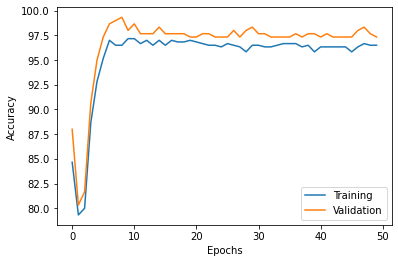

In [24]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc, label="Training")
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc, label="Validation")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(loc="lower right")
# plt.savefig('figures/11_08.png', dpi=300)
plt.show()

In [25]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f"Test accuracy: {test_acc*100:.2f}%")

Test accuracy: 98.00%


### Full Back Propagation


What we did above, backpropagated considering there is only one unit in each layer but the deep neural network we had built was not like that, for example, in reality, looking at the diagram, $W_{11}^{(1)}$ affects the output for both $A_{1}^{(o)}$ and $A_{2}^{(o)}$.Because our cost function is a summation of individual costs for each output, we have to use the _multi-variable chain rule_ to sum the two paths highlighted with blue and red arrows and simply add them together, so $W_{11}^{(1)}$ would be:

$$
\frac{{\partial L\left( W  \right)}}{{\partial W _{11}^{(1)}}} = \left( {\frac{{\partial L\left( W  \right)}}{{\partial A _1^{(o)}}}} \right)\left( {\frac{{\partial A _1^{(o)}}}{{\partial Z _1^{(o)}}}} \right)\left( {\frac{{\partial Z _1^{(o)}}}{{\partial A _1^{(1)}}}} \right)\left( {\frac{{\partial A _1^{(1)}}}{{\partial Z _1^{(1)}}}} \right)\left( {\frac{{\partial Z _1^{(1)}}}{{\partial W _{11}^{(1)}}}} \right) + \left( {\frac{{\partial L\left( W  \right)}}{{\partial A _2^{(o)}}}} \right)\left( {\frac{{\partial A _2^{(o)}}}{{\partial Z _2^{(o)}}}} \right)\left( {\frac{{\partial Z _2^{(o)}}}{{\partial A _1^{(1)}}}} \right)\left( {\frac{{\partial A _1^{(1)}}}{{\partial Z _1^{(1)}}}} \right)\left( {\frac{{\partial Z _1^{(1)}}}{{\partial W _{11}^{(1)}}}} \right)
$$

<p align="center">
<img src="img/full_backprop.jpg" alt="full_backprop.jpg.jpg" width="800px"/>
</p>


So the Layer 1 Parameters:

$$\frac{{\partial L\left( W  \right)}}{{\partial W _{11}^{(1)}}} = \left( {\frac{{\partial L\left( W  \right)}}{{\partial A _1^{(o)}}}} \right)\left( {\frac{{\partial A _1^{(o)}}}{{\partial Z _1^{(o)}}}} \right)\left( {\frac{{\partial Z _1^{(o)}}}{{\partial A _1^{(1)}}}} \right)\left( {\frac{{\partial A _1^{(1)}}}{{\partial Z _1^{(1)}}}} \right)\left( {\frac{{\partial Z _1^{(1)}}}{{\partial W _{11}^{(1)}}}} \right) + \left( {\frac{{\partial L\left( W  \right)}}{{\partial A _2^{(o)}}}} \right)\left( {\frac{{\partial A _2^{(o)}}}{{\partial Z _2^{(o)}}}} \right)\left( {\frac{{\partial Z _2^{(o)}}}{{\partial A _1^{(1)}}}} \right)\left( {\frac{{\partial A _1^{(1)}}}{{\partial Z _1^{(1)}}}} \right)\left( {\frac{{\partial Z _1^{(1)}}}{{\partial W _{11}^{(1)}}}} \right)$$

$$\frac{{\partial L\left( W  \right)}}{{\partial W _{12}^{(1)}}} = \left( {\frac{{\partial L\left( W  \right)}}{{\partial A _1^{(o)}}}} \right)\left( {\frac{{\partial A _1^{(o)}}}{{\partial Z _1^{(o)}}}} \right)\left( {\frac{{\partial Z _1^{(o)}}}{{\partial A _1^{(1)}}}} \right)\left( {\frac{{\partial A _1^{(1)}}}{{\partial Z _1^{(1)}}}} \right)\left( {\frac{{\partial Z _1^{(1)}}}{{\partial W _{12}^{(1)}}}} \right) + \left( {\frac{{\partial L\left( W  \right)}}{{\partial A _2^{(o)}}}} \right)\left( {\frac{{\partial A _2^{(o)}}}{{\partial Z _2^{(o)}}}} \right)\left( {\frac{{\partial Z _2^{(o)}}}{{\partial A _1^{(1)}}}} \right)\left( {\frac{{\partial A _1^{(1)}}}{{\partial Z _1^{(1)}}}} \right)\left( {\frac{{\partial Z _1^{(1)}}}{{\partial W _{12}^{(1)}}}} \right)$$

$$\frac{{\partial L\left( W  \right)}}{{\partial W _{21}^{(1)}}} = \left( {\frac{{\partial L\left( W  \right)}}{{\partial A _1^{(o)}}}} \right)\left( {\frac{{\partial A _1^{(o)}}}{{\partial Z _1^{(o)}}}} \right)\left( {\frac{{\partial Z _1^{(o)}}}{{\partial A _2^{(1)}}}} \right)\left( {\frac{{\partial A _2^{(1)}}}{{\partial Z _2^{(1)}}}} \right)\left( {\frac{{\partial Z _2^{(1)}}}{{\partial W _{21}^{(1)}}}} \right) + \left( {\frac{{\partial L\left( W  \right)}}{{\partial A _2^{(o)}}}} \right)\left( {\frac{{\partial A _2^{(o)}}}{{\partial Z _2^{(o)}}}} \right)\left( {\frac{{\partial Z _2^{(o)}}}{{\partial A _2^{(1)}}}} \right)\left( {\frac{{\partial A _2^{(1)}}}{{\partial Z _2^{(1)}}}} \right)\left( {\frac{{\partial Z _2^{(1)}}}{{\partial W _{21}^{(1)}}}} \right)$$

$$\frac{{\partial L\left( W  \right)}}{{\partial W _{22}^{(1)}}} = \left( {\frac{{\partial L\left( W  \right)}}{{\partial A _1^{(o)}}}} \right)\left( {\frac{{\partial A _1^{(o)}}}{{\partial Z _1^{(o)}}}} \right)\left( {\frac{{\partial Z _1^{(o)}}}{{\partial A _2^{(1)}}}} \right)\left( {\frac{{\partial A _2^{(1)}}}{{\partial Z _2^{(1)}}}} \right)\left( {\frac{{\partial Z _2^{(1)}}}{{\partial W _{22}^{(1)}}}} \right) + \left( {\frac{{\partial L\left( W  \right)}}{{\partial A _2^{(o)}}}} \right)\left( {\frac{{\partial A _2^{(o)}}}{{\partial Z _2^{(o)}}}} \right)\left( {\frac{{\partial Z _2^{(o)}}}{{\partial A _2^{(1)}}}} \right)\left( {\frac{{\partial A _2^{(1)}}}{{\partial Z _2^{(1)}}}} \right)\left( {\frac{{\partial Z _2^{(1)}}}{{\partial W _{22}^{(1)}}}} \right)$$

Layer 2/Output Layer Parameters:

$$\frac{{\partial L\left( W\right)}}{{\partial W_{11}^{(o)}}} = \left( {\frac{{\partial L\left( W\right)}}{{\partial A_1^{(o)}}}} \right)\left( {\frac{{\partial A_1^{(o)}}}{{\partial Z _1^{(o)}}}} \right)\left( {\frac{{\partial Z _1^{(o)}}}{{\partial W_{11}^{(o)}}}} \right)$$

$$\frac{{\partial L\left( W\right)}}{{\partial W_{12}^{(o)}}} = \left( {\frac{{\partial L\left( W\right)}}{{\partial A_1^{(o)}}}} \right)\left( {\frac{{\partial A_1^{(o)}}}{{\partial Z _1^{(o)}}}} \right)\left( {\frac{{\partial Z _1^{(o)}}}{{\partial W_{12}^{(o)}}}} \right)$$

$$\frac{{\partial L\left( W\right)}}{{\partial W_{21}^{(o)}}} = \left( {\frac{{\partial L\left( W\right)}}{{\partial A_2^{(o)}}}} \right)\left( {\frac{{\partial A_2^{(o)}}}{{\partial Z _2^{(o)}}}} \right)\left( {\frac{{\partial Z _2^{(o)}}}{{\partial W_{21}^{(o)}}}} \right)$$

$$\frac{{\partial L\left( W\right)}}{{\partial W_{22}^{(o)}}} = \left( {\frac{{\partial L\left( W\right)}}{{\partial A_2^{(o)}}}} \right)\left( {\frac{{\partial A_2^{(o)}}}{{\partial Z _2^{(o)}}}} \right)\left( {\frac{{\partial Z _2^{(o)}}}{{\partial W_{22}^{(o)}}}} \right)$$


### Generalizing Backpropagation


Let's examine the partial derivatives above and make a few observations. We'll start with looking at the partial derivatives with respect to the parameters for layer 1. Remember, the parameters in for layer 1 are combined with the activations in layer 1 to feed as inputs into layer 2.


**Layer 2/Output Layer Parameters**:

$$\frac{{\partial L\left( W\right)}}{{\partial W_{11}^{(2)}}} = \left( {\frac{{\partial L\left( W\right)}}{{\partial A_1^{(2)}}}} \right)\left( {\frac{{\partial A_1^{(2)}}}{{\partial Z _1^{(2)}}}} \right)\left( {\frac{{\partial Z _1^{(2)}}}{{\partial W_{11}^{(2)}}}} \right)$$

$$\frac{{\partial L\left( W\right)}}{{\partial W_{12}^{(2)}}} = \left( {\frac{{\partial L\left( W\right)}}{{\partial A_1^{(2)}}}} \right)\left( {\frac{{\partial A_1^{(2)}}}{{\partial Z _1^{(2)}}}} \right)\left( {\frac{{\partial Z _1^{(2)}}}{{\partial W_{12}^{(2)}}}} \right)$$

$$\frac{{\partial L\left( W\right)}}{{\partial W_{21}^{(2)}}} = \left( {\frac{{\partial L\left( W\right)}}{{\partial A_2^{(2)}}}} \right)\left( {\frac{{\partial A_2^{(2)}}}{{\partial Z _2^{(2)}}}} \right)\left( {\frac{{\partial Z _2^{(2)}}}{{\partial W_{21}^{(2)}}}} \right)$$

$$\frac{{\partial L\left( W\right)}}{{\partial W_{22}^{(2)}}} = \left( {\frac{{\partial L\left( W\right)}}{{\partial A_2^{(2)}}}} \right)\left( {\frac{{\partial A_2^{(2)}}}{{\partial Z _2^{(2)}}}} \right)\left( {\frac{{\partial Z _2^{(2)}}}{{\partial W_{22}^{(2)}}}} \right)$$

Foremost, it seems as if the columns contain very similar values. For example, **The first and second columns can be combined as** $ \delta \_i^{(2)}$ for the sake of convenience later on down the road. People will often refer to this expression as the **"error"** term which we use to _"send back error from the output throughout the network"_. We'll see why this is the case soon. Each neuron in the network will have a corresponding $ \delta_i^{(2)}$ term that we'll solve for.

$$\delta _i^{(2)} =\left( {\frac{{\partial L\left( W\right)}}{{\partial A_i^{(2)}}}} \right)\left( {\frac{{\partial A_i^{(2)}}}{{\partial Z _i^{(2)}}}} \right)= \frac{1}{m}\left( {{y _i} - A _i^{(2)}} \right)\sigma'\left( {{A^{(2)}}} \right)$$

We know $\sigma'\left( {{A^{(2)}}} \right)$ or the derivative of the sigmoid activation function is given by $\sigma'\left( {{A^{(2)}}} \right) =  A_2 * (1 - A_2)$

The **third column** represents how the parameter of interest changes with respect to the weighted inputs for the current layer; when you calculate the derivative this corresponds with the activation from the previous layer.


$$\frac{{\partial L\left( W\right)}}{{\partial W_{12}^{(2)}}} = \delta _1^{(2)}\left( {\frac{{\partial Z _1^{(2)}}}{{\partial W_{12}^{(2)}}}} \right) = \delta _1^{(2)}\cdot A_{1}^{(1)}$$

$$\frac{{\partial L\left( W\right)}}{{\partial W_{12}^{(2)}}} = \delta _1^{(2)}\left( {\frac{{\partial Z _1^{(2)}}}{{\partial W_{12}^{(2)}}}} \right) = \delta _1^{(2)}\cdot A_{2}^{(1)}$$

$$\frac{{\partial L\left( W\right)}}{{\partial W_{21}^{(2)}}} =\delta _2^{(2)}\left( {\frac{{\partial Z _2^{(2)}}}{{\partial W_{21}^{(2)}}}} \right) = \delta _2^{(2)}\cdot A_{1}^{(1)}$$

$$\frac{{\partial L\left( W\right)}}{{\partial W_{22}^{(2)}}} = \delta _2^{(2)}\left( {\frac{{\partial Z _2^{(2)}}}{{\partial W_{22}^{(2)}}}} \right) = \delta _2^{(2)}\cdot A_{2}^{(1)}$$


It appears that we're **combining the `"error"` terms with `activations` from the previous layer ( ${\frac{{\partial Z^{(2)}}}{{\partial W^{(2)}}}}= A^{(1)}$) to calculate each partial derivative**

It's also interesting to note that the indices $j$ and $k$ for $W_{jk}$ match the combined indices of $\delta,A$

$$\frac{{\partial L\left( W\right)}}{{\partial W_{jk}^{(2)}}} =  \delta _j^{(2)}\cdot A_{k}^{(1)}$$

Let's see if we can figure out a matrix operation to compute all of the partial derivatives in one expression.

$$
\frac{{\partial L\left( W\right)}}{{\partial W_{jk}^{(2)}}} =  \begin{bmatrix}\delta _1^{(2)} \\ \delta _2^{(2)} \end{bmatrix}
\begin{bmatrix}A_{1}^{(1)} & A_{2}^{(1)} \end{bmatrix} =
\begin{bmatrix}\delta _1^{(2)}\cdot A_{1}^{(1)} & \delta _1^{(2)}\cdot A_{2}^{(1)} \\ \delta _2^{(2)}\cdot A_{1}^{(1)} & \delta _2^{(2)}\cdot A_{2}^{(1)} \end{bmatrix}
$$

Or

$$\frac{{\partial L\left( W\right)}}{{\partial W_{jk}^{(l)}}} =  \delta _j^{(l)}\cdot A_{k}^{(l-1)}$$

To summarize, see the graphic below.

<p align="center">
<img src="img/l2_general.jpg" alt="l2_general.jpg" width="400px"/>
</p>


**Layer 1 Parameters:**
Now let's take a look and see what's going on in layer 1.

Whereas the weights in layer 2 only directly affected one output, the weights in layer 1 affect all of the outputs. Recall the following graphic.

This results in a partial derivative of the cost function with respect to a parameter now becoming a summation of different chains. Specifically, we'll have a derivative chain for every $\delta$ we calculated in the next layer forward. Remember, we started at the end of the network and are working our way backwards through the network. Thus, the next layer forward represents the $\delta$ values that we previously calculated.

<p align="center">
<img src="img/l1_general.jpg" alt="l1_general.jpg" width="800px"/>
</p>


As we did for layer 2, let's make a few observations.

The **first two columns** (of each summed term) corresponds with a $\delta_j^{(2)}$ calculated in the next layer forward (remember, we started at the end of the network and are working our way back).

The **third column** corresponds with some parameter that connects layer 1 to layer 2. If we considered $\delta_j^{(2)}$ to be some **"error"** term for layer 2, and each derivative chain is now a summation of these errors, then this third column allows us to **weight** each respective error. Thus, the first three terms combined represent some measure of the **"proportional error"**.

We'll also redefine $\delta$ for all layers excluding the output layer to include this combination of weighted errors.

$$\delta _j^{(l)} =\left( \sum\limits _{i = 1}^n {\delta _i^{(l + 1)}W_{ij}^{(l+1)}}\right) \cdot \sigma'\left({{a^{(l)}}} \right)$$

We could write this more succinctly using matrix expressions.

$${\delta ^{(l)}} = {\delta ^{(l + 1)}}\cdot{W ^{(l+1)}}\cdot\sigma'\left( {{A^{(l)}}} \right)$$

The **fourth column** represents the derivative of the activation function used in the current layer. Remember that for each layer, neurons will use the same activation function.

Lastly, the **fifth column** represents various inputs from the previous layer. In this case, it is the actual inputs to the neural network.


Let's take a closer look at one of the terms $\frac{{\partial L\left( W  \right)}}{{\partial W^{(1)}}}$


Foremost, we established that the first two columns of each derivative chains were previously calculated as $\delta_{j}^{(2)}$. Further, we established the the third columns of each derivative chain was a parameter that acted to weight each of the respective $\delta$ terms. We also established that the fourth column was the derivative of the activation function.


$$\frac{{\partial L\left( W  \right)}}{{\partial W _{11}^{(1)}}} = \delta_1^{(2)} \cdot{W_{11} ^{(2)}}\cdot\sigma'\left( {{A^{(1)}}} \right) \left( {\frac{{\partial Z _1^{(1)}}}{{\partial W _{11}^{(1)}}}} \right) + \delta_2^{(2)} \cdot{W_{21} ^{(2)}}\cdot\sigma'\left( {{A^{(1)}}} \right) \left( {\frac{{\partial Z _1^{(1)}}}{{\partial W _{11}^{(1)}}}} \right)$$


Factoring out $\left( {\frac{{\partial Z _1^{(1)}}}{{\partial W _{11}^{(1)}}}} \right)$,

$$\frac{{\partial L\left( W  \right)}}{{\partial W _{11}^{(1)}}} = \left( {\frac{{\partial Z _1^{(1)}}}{{\partial W _{11}^{(1)}}}} \right)   \left( \delta_1^{(2)} \cdot{W_{11} ^{(2)}}\cdot\sigma'\left( {{A^{(1)}}} \right)+ \delta_2^{(2)} \cdot{W_{21} ^{(2)}}\cdot\sigma'\left( {{A^{(1)}}} \right) \right)$$


Substituting with $\delta_{j}^{l}$,


$$\frac{{\partial L\left( W  \right)}}{{\partial W _{11}^{(1)}}} = \left( {\frac{{\partial Z _1^{(1)}}}{{\partial W _{11}^{(1)}}}} \right) \left( \delta_{1}^{(1)}\right)$$


Lastly, we established the **fifth column** $\left( {\frac{{\partial Z _1^{(1)}}}{{\partial W _{11}^{(1)}}}} \right)$ corresponded with an input from the previous layer. In this case, the derivative calculates to be
$x_1$.


$$\frac{{\partial L\left( W  \right)}}{{\partial W _{11}^{(1)}}} = x_1 \delta_{1}^{(1)}$$


Generally, we established that you can calculate the partial derivatives for layer $l$ by combining error - $\delta$ terms with the activations of the current layer.


$$\frac{{\partial L\left( W  \right)}}{{\partial W^{(l)}}} = \left( \delta^{(l)}\right)^{T}A^{l}$$


A formalized method for implementing backpropagation: Here, I'll present a practical method for implementing backpropagation through a network of layers $l=1,2,3....L$


1. Perform forward propagation.
2. Compute the $\delta$ term for the output layer.

$$\delta _i^{(L)} = \frac{1}{m}\left( {{y _i} - A _i^{(L)}} \right)\sigma'\left( {{A^{(L)}}} \right)$$

3. Compute the partial derivatives of the cost function with respect to all of the parameters that feed into the output layer, $W^{(L)}$
   $$\frac{{\partial L\left( W  \right)}}{{\partial W^{(L)}}} = \left( \delta^{(L)}\right)^{T}A^{L}$$
4. **Update Weights and Biases for the output layer:**
   - $W^{(L)} = W^{(L)} - \alpha \frac{\partial L(W)}{\partial W^{(L)}}$,
   - $b^{(L)} = b^{(L)} - \alpha \frac{1}{m} \sum_{i=1}^{m} \delta_i^{(L)}$.
5. Go back one layer. $l=l-1$
6. Compute the $\delta$ term for the hidden.
   $${\delta ^{(l)}} = {\delta ^{(l + 1)}}\cdot{W ^{(l+1)}}\cdot\sigma'\left( {{A^{(l)}}} \right)$$
7. Compute the partial derivatives of the cost function with respect to all of the parameters that feed into the current layer.
   $$\frac{{\partial L\left( W  \right)}}{{\partial W^{(l)}}} = \left( \delta^{(l)}\right)^{T}A^{l}$$
8. **Update Weights and Biases:**
   - $W^{(l)} = W^{(l)} - \alpha \frac{\partial L(W)}{\partial W^{(l)}}$,
   - $b^{(l)} = b^{(l)} - \alpha \frac{1}{m} \sum_{i=1}^{m} \delta_i^{(l)}$.
9. Repeat 5 through 8 until you reach the input layer.


Epoch: 001/050 | Train MSE: 0.30 | Train Acc: 49.00% | Valid Acc: 51.00%
Epoch: 011/050 | Train MSE: 0.29 | Train Acc: 91.50% | Valid Acc: 93.33%
Epoch: 021/050 | Train MSE: 0.27 | Train Acc: 96.83% | Valid Acc: 98.00%


Epoch: 031/050 | Train MSE: 0.18 | Train Acc: 96.50% | Valid Acc: 97.67%
Epoch: 041/050 | Train MSE: 0.09 | Train Acc: 96.67% | Valid Acc: 97.67%


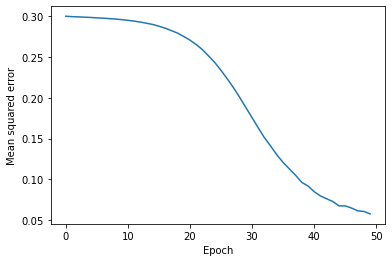

In [244]:
num_epochs = 50  # Number of training epochs
epoch_loss = []
epoch_train_acc = []
epoch_valid_acc = []

model = Sequential(
    [
        Linear(2, 10),
        Sigmoid(),
        Linear(10, 5),
        Sigmoid(),
        Linear(5, n_classes),
        Sigmoid(),
    ]
)


def backward_weight_update(model, X, y, learning_rate=0.1):
    # Forward pass
    _ = model(X)
    last_activation, last_linear, input = -1, -2, -3
    # Convert integer labels 'y' to one-hot encoded format
    onehot_targets = int_to_onehot(y, num_labels=2)
    # Output error
    error = model.outputs[last_activation] - onehot_targets

    # Initialize deltas
    deltas = [None] * len(model.outputs)

    # Calculate delta for output layer
    d_loss_dA_out = 2 * (error) / y.shape[0]
    dA_out_dZ_out = model.outputs[last_activation] * (
        1 - model.outputs[last_activation]
    )
    deltas[last_activation] = d_loss_dA_out * dA_out_dZ_out  # The error term

    dZ_dW = model.outputs[input]  # input from previous layer
    d_loss__dW = np.dot(deltas[last_activation].T, dZ_dW)
    d_loss__db = np.sum(deltas[last_activation], axis=0)
    model.layers[last_linear].weight -= learning_rate * d_loss__dW
    model.layers[last_linear].bias -= learning_rate * d_loss__db

    # Backpropagate deltas through l=l-1 layers
    last_activation -= 2
    last_linear -= 2
    input -= 2

    while last_activation + len(deltas) >= 1:
        # print(last_activation, input, len(deltas))
        # Calculate error term for hidden layer
        propagated_error = deltas[last_activation + 2]
        dZ_dA = model.layers[last_linear + 2].weight
        proportional_error = np.dot(propagated_error, dZ_dA)
        dA_dZ = model.outputs[last_activation] * (1 - model.outputs[last_activation])
        deltas[last_activation] = proportional_error * dA_dZ

        if last_activation + len(deltas) == 1:
            # input layer reached
            dZ_dW = X
        else:
            # else previous layer output as input for current layer
            dZ_dW = model.outputs[input]  # input from previous layer
        d_loss__dW = np.dot(deltas[last_activation].T, dZ_dW)
        d_loss__db = np.sum(deltas[last_activation], axis=0)

        # Update weights and biases for linear layer
        model.layers[last_linear].weight -= learning_rate * d_loss__dW
        model.layers[last_linear].bias -= learning_rate * d_loss__db

        last_activation -= 2
        last_linear -= 2
        input -= 2

    return model


for epoch in range(num_epochs):
    # Forward and backward passes with weight update
    # iterate over minibatches
    minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size=100)

    for X_mini, y_mini in minibatch_gen:
        model = backward_weight_update(model, X_mini, y_mini, learning_rate=0.25)
    #### Epoch Logging ####
    train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
    valid_mse, valid_acc = compute_mse_and_acc(model, X_test, y_test)
    train_acc, valid_acc = train_acc * 100, valid_acc * 100
    epoch_train_acc.append(train_acc)
    epoch_valid_acc.append(valid_acc)
    epoch_loss.append(train_mse)
    if epoch % 10 == 0:
        print(
            f"Epoch: {epoch+1:03d}/{num_epochs:03d} "
            f"| Train MSE: {train_mse:.2f} "
            f"| Train Acc: {train_acc:.2f}% "
            f"| Valid Acc: {valid_acc:.2f}%"
        )

plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel("Mean squared error")
plt.xlabel("Epoch")
# plt.savefig('figures/11_07.png', dpi=300)
plt.show()

## Re-Building MLP with PyTorch


The most commonly used approach for building an NN in PyTorch is through `nn.Module`, which allows
layers to be stacked to form a network. This gives control over both the forward pass (how data moves through the network) and the backward pass (how gradients are computed during training).


(1000, 2) (1000,)


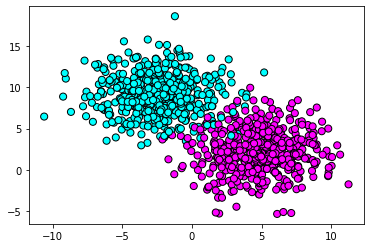

In [8]:
X_train, X_test, y_train, y_test = generate_blob_cluster(split_train_test=True)
X_train, X_test, y_train, y_test = (
    torch.tensor(X_train).float(),
    torch.tensor(X_test).float(),
    torch.tensor(y_train).float(),
    torch.tensor(y_test).float(),
)

In [4]:
train_ds = TensorDataset(X_train, y_train)
batch_size = 20
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

### Into to Pytorch AutoGrad, LossFn


Epoch [1/50], Loss: 0.6968660354614258
Epoch [11/50], Loss: 0.4909517168998718
Epoch [21/50], Loss: 0.44125431776046753
Epoch [31/50], Loss: 0.40942731499671936
Epoch [41/50], Loss: 0.39606401324272156


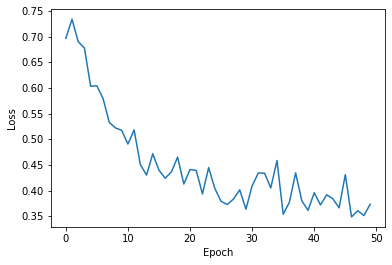

In [13]:
n_features = 2
n_hidden_1 = 10
n_classes = 2

torch.manual_seed(0)
W1 = torch.randn(n_hidden_1, n_features, requires_grad=True)
b1 = torch.zeros(n_hidden_1, requires_grad=True)
W2 = torch.randn(n_classes, n_hidden_1, requires_grad=True)
b2 = torch.zeros(n_classes, requires_grad=True)


def model(X):
    a1 = torch.matmul(X, W1.T) + b1  # (N,f) x (h1,f)^T => (N,h1)
    h1 = a1.sigmoid()  # (N,h1)
    a2 = torch.matmul(h1, W2.T) + b2  # (N,h1) x (h2,h1)^T => (N,h2)
    h2 = a2.sigmoid()  # (N,h2)
    return h2


loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.NLLLoss()

learning_rate = 0.1
num_epochs = 50
log_epochs = 10
epoch_losses = []

for epoch in range(num_epochs):
    for X_batch, y_batch in train_dl:
        # Forward pass
        outputs = model(X_batch)
        # Calculate loss
        loss = loss_fn(outputs, y_batch.long())
        # Compute gradients
        loss.backward()
        # Update weights and biases
        with torch.no_grad():
            """
            When you update weights manually using plain tensor operations like `W1 -= learning_rate * W1.grad`, these operations themselves are not part of the computation graph and should not have associated gradients. Hence, wrapping these weight update operations inside torch.no_grad() allows you to perform the updates without autograd tracking, preventing unnecessary memory consumption for gradient computation and potential interference with your manual updates.
            """
            W1 -= learning_rate * W1.grad
            b1 -= learning_rate * b1.grad
            W2 -= learning_rate * W2.grad
            b2 -= learning_rate * b2.grad

            # Zero gradients
            W1.grad.zero_()
            b1.grad.zero_()
            W2.grad.zero_()
            b2.grad.zero_()
            """
            By zeroing the gradients with `optimizer.zero_grad()` at the beginning of each minibatch or iteration, you ensure that the gradients from the previous iterations don't interfere with the current computation.
            """

    epoch_losses.append(loss.item())

    # Logging
    if epoch % log_epochs == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}")

plt.plot(range(len(epoch_losses)), epoch_losses)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

### Intro to Pytorch Optimizers and training loop


`torch.optim` provides a wide array of optimization algorithms, such as SGD, Adam, RMSprop, etc., to automatically update model parameters based on computed gradients during backpropagation.

Using `torch.optim` simplifies training as it handles the weight updates for you. You simply define an optimizer, pass it the parameters to optimize, compute gradients with `loss.backward()`, and then call `optimizer.step()` to update the weights accordingly. This allows you to focus on designing complex models while the library takes care of the optimization process.


Epoch [1/50], Loss: 0.6361538171768188


Epoch [11/50], Loss: 0.3223415017127991
Epoch [21/50], Loss: 0.3679538667201996
Epoch [31/50], Loss: 0.3408721387386322
Epoch [41/50], Loss: 0.36326706409454346


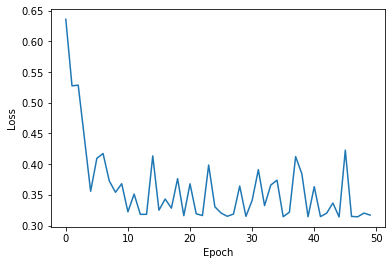

In [38]:
torch.manual_seed(0)
n_features = 2
n_hidden_1 = 10
n_classes = 2


W1 = torch.randn(n_hidden_1, n_features, requires_grad=True)
b1 = torch.zeros(n_hidden_1, requires_grad=True)
W2 = torch.randn(n_classes, n_hidden_1, requires_grad=True)
b2 = torch.zeros(n_classes, requires_grad=True)


def model(X):
    a1 = torch.matmul(X, W1.T) + b1  # (N,f) x (h1,f)^T => (N,h1)
    h1 = a1.sigmoid()  # (N,h1)
    a2 = torch.matmul(h1, W2.T) + b2  # (N,h1) x (h2,h1)^T => (N,h2)
    h2 = a2.sigmoid()  # (N,h2)
    return h2


loss_fn = nn.CrossEntropyLoss()
# updating through optimizer
optimizer = torch.optim.Adam([W1, b1, W2, b2], lr=0.015)

epoch_losses = []
for epoch in range(num_epochs):
    for batch in train_dl:
        X, y = batch
        # 1. Zero the gradients for a fresh start
        optimizer.zero_grad()
        # 2. Forward pass
        outputs = model(X)
        # 3. Calculate loss
        loss = loss_fn(outputs, y.long())
        # 4. Compute gradients
        loss.backward()
        # 5. Update Parameters
        optimizer.step()

        # with torch.no_grad():
        #     W1 -= learning_rate * W1.grad
        #     b1 -= learning_rate * b1.grad
        #     W2 -= learning_rate * W2.grad
        #     b2 -= learning_rate * b2.grad

        #     # Zero gradients
        #     W1.grad.zero_()
        #     b1.grad.zero_()
        #     W2.grad.zero_()
        #     b2.grad.zero_()

    epoch_losses.append(loss.item())

    # Logging

    if epoch % log_epochs == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}")

plt.plot(range(len(epoch_losses)), epoch_losses)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

For the **`training loop`**, we'll build the following steps:

<table>
<thead>
  <tr>
    <th>Step Names</th>
    <th>Code example</th>
    <th>What does it do?</th>
  </tr>
</thead>
<tbody>
 <tr>
    <td><b>Zero gradients</b></td>
    <td><code>optimizer.zero_grad()</code></td>
    <td>The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step.</td>
  </tr>
  <tr>
    <td><b> Forward pass</b></td>
    <td><code>model(x_train)</code></td>
    <td>The model goes through all of the training data once, performing its forward() function calculations.</td>
  </tr>
  <tr>
    <td><b>Calculate the loss</b></td>
    <td><code>loss = loss_fn(y_pred, y_train)</code></td>
    <td>The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are.</td>
  </tr>
 
  <tr>
    <td><b>Perform backpropagation on the loss</b></td>
    <td><code>loss.backward()</code></td>
    <td>Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with <code>requires_grad=True</code>). This is known as backpropagation, hence "backwards".</td>
  </tr>
  <tr>
    <td><b>Update the optimizer (gradient descent)</b></td>
    <td><code>optimizer.step()</code></td>
    <td>Update the parameters with requires_grad=True with respect to the loss gradients in order to improve them.</td>
  </tr>
</tbody>
</table>

<div align="center">
<img src="img/01-pytorch-training-loop-annotated.png" alt="train" width="1000px">
</div>

**_And on the ordering of things, the above is a good default order but you may see slightly different orders_**. Some rules of thumb:

- **Calculate the loss** (`loss = ...`) **before performing backpropagation** on it (`loss. backward()`).
- **Zero gradients** (`optimizer.zero_grad()`) **before stepping them** (`optimizer.step()`).
- **Step the optimizer** (`optimizer.step()`) **after performing backpropagation on the loss** (`loss.backward()`).


### Building Class-based Model with `nn.Module`


By subclassing `nn.Module`, we create a new class derived from nn.Module and define the method, `__init__()`, as a constructor. The `forward()` method is used to specify the forward pass. In the constructor function, `__init__()`, we define the layers as attributes of the class so that they can be accessed via the self reference attribute. Then, in the `forward()` method, we specify how these layers are to be used in the forward pass of the NN.


#### Optimizing Parameters with `nn.Parameter`


`nn.Parameter` in PyTorch is a class used to **explicitly mark parameters to be optimized during training**, negating the need to manually specify parameters (e.g., `Adam([W1, b1, W2, b2], lr=0.1)`). Instead, parameters defined within the model can be accessed through `Adam(model.parameters(), lr=0.01)`.


In [10]:
class Model(nn.Module):
    def __init__(self, input_features=2, n_hidden=10, output_features=2):
        super().__init__()
        torch.manual_seed(0)
        # self.W1 = torch.randn(n_hidden_1, n_features, requires_grad=True)
        # self.b1 = torch.zeros(n_hidden_1, requires_grad=True)
        # self.W2 = torch.randn(n_classes, n_hidden_1, requires_grad=True)
        # self.b2 = torch.zeros(n_classes, requires_grad=True)
        self.W1 = nn.Parameter(torch.randn(n_hidden, input_features))
        self.b1 = nn.Parameter(torch.zeros(n_hidden))
        self.W2 = nn.Parameter(torch.randn(output_features, n_hidden))
        self.b2 = nn.Parameter(torch.zeros(output_features))

    def forward(self, X):
        a1 = torch.matmul(X, self.W1.T) + self.b1
        h1 = a1.sigmoid()
        a2 = torch.matmul(h1, self.W2.T) + self.b2
        h2 = a2.sigmoid()
        return h2


model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

Epoch [1/50], Loss: 0.7436052560806274


Epoch [40/50], Loss: 0.3408917784690857


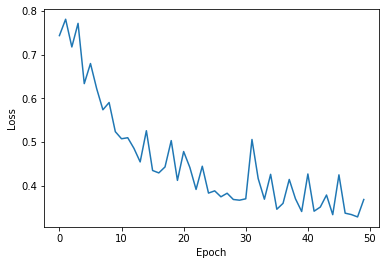

In [11]:
epoch_losses = []
num_epochs = 50
log_epochs = 39

for epoch in range(num_epochs):
    for X_batch, y_batch in train_dl:
        # Forward pass
        outputs = model(X_batch)
        # Calculate loss
        loss = loss_fn(outputs, y_batch.long())
        # Compute gradients

        loss.backward()
        # Update weights and biases
        optimizer.step()
        optimizer.zero_grad()

    epoch_losses.append(loss.item())

    # Logging
    if epoch % log_epochs == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}")

plt.plot(range(len(epoch_losses)), epoch_losses)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

#### `nn.Linear`


For this problem, we are going to use the `Linear` layer, which is also known as a fully connected layer or dense layer, and can be best represented by `f(w×x+b)`, where `x` represents a tensor containing the input features, `w` and `b` are the weight matrix and the bias vector, and `f` is the activation function.

**Each layer in an NN receives its inputs from the preceding layer**; _therefore, its dimensionality (rank
and shape) is fixed. Typically, we need to concern ourselves with the dimensionality of output only
when we design an NN architecture_. Here, we want to define a model with two hidden layers. _The first
one receives an input of four features and projects them to 16 neurons. The second layer receives the
output of the previous layer (which has a size of 16) and projects them to three output neurons, since
we have three class labels. This can be done as follows:_


In [12]:
class Model(nn.Module):
    def __init__(self, input_features=2, n_hidden=10, output_features=2):
        super().__init__()
        torch.manual_seed(0)
        # self.W1 = nn.Parameter(torch.randn(n_hidden, input_features))
        # self.b1 = nn.Parameter(torch.zeros(n_hidden))
        # self.W2 = nn.Parameter(torch.randn(output_features, n_hidden))
        # self.b2 = nn.Parameter(torch.zeros(output_features))

        self.layer1 = nn.Linear(input_features, n_hidden)
        self.layer2 = nn.Linear(n_hidden, output_features)

    def forward(self, x):
        # a1 = torch.matmul(X, self.W1.T) + b1
        # h1 = a1.sigmoid()
        # a2 = torch.matmul(h1, self.W2.T) + b2
        # h2 = a2.softmax(dim=1)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        return x


input_feature = X_train.shape[1]
n_hidden = 16
output_feature = 2

model = Model(input_feature, n_hidden, output_feature)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

In [13]:
num_epochs = 100
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        optimizer.zero_grad()
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch.long())
        loss.backward()
        optimizer.step()

        loss_hist[epoch] += loss.item() * y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()

    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)

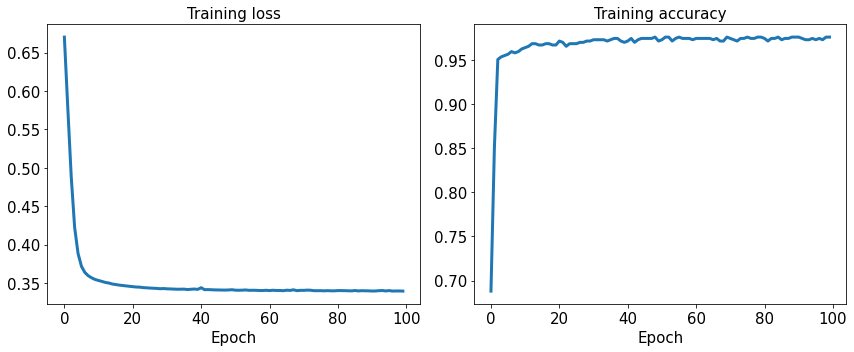

In [23]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title("Training loss", size=15)
ax.set_xlabel("Epoch", size=15)
ax.tick_params(axis="both", which="major", labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title("Training accuracy", size=15)
ax.set_xlabel("Epoch", size=15)
ax.tick_params(axis="both", which="major", labelsize=15)
plt.tight_layout()

# plt.savefig('figures/12_09.pdf')

plt.show()

### Complete train and validation loop


In [22]:
def train(model, num_epochs, train_dl, x_valid, y_valid, log_epochs=10):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        for x_batch, y_batch in train_dl:
            optimizer.zero_grad()
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch.long())
            loss.backward()
            optimizer.step()
            loss_hist_train[epoch] += loss.item()
            is_correct = (torch.argmax(pred, axis=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.mean()

        loss_hist_train[epoch] /= len(train_dl.dataset) / batch_size
        accuracy_hist_train[epoch] /= len(train_dl.dataset) / batch_size
        #### Validation Starts ####
        # put model in evaluation model
        model.eval()
        # turn on inference mode
        with torch.inference_mode():
            pred = model(x_valid)
            loss = loss_fn(pred, y_valid.long())
            loss_hist_valid[epoch] = loss.item()
            is_correct = (torch.argmax(pred, axis=1) == y_valid).float()
            accuracy_hist_valid[epoch] += is_correct.mean()
            # Logging
            if epoch % log_epochs == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}")
    return {
        "loss_train": loss_hist_train,
        "loss_valid": loss_hist_valid,
        "accuracy_train": accuracy_hist_train,
        "accuracy_valid": accuracy_hist_valid,
    }


torch.manual_seed(1)
num_epochs = 200
log_epochs = 39
model = Model(input_feature, n_hidden, output_feature)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
history = train(
    model,
    num_epochs=num_epochs,
    train_dl=train_dl,
    x_valid=X_test,
    y_valid=y_test,
    log_epochs=log_epochs,
)

Epoch [1/200], Loss: 0.6914540529251099
Epoch [40/200], Loss: 0.34239593148231506
Epoch [79/200], Loss: 0.33487212657928467
Epoch [118/200], Loss: 0.3322422504425049
Epoch [157/200], Loss: 0.33055779337882996
Epoch [196/200], Loss: 0.3301910161972046


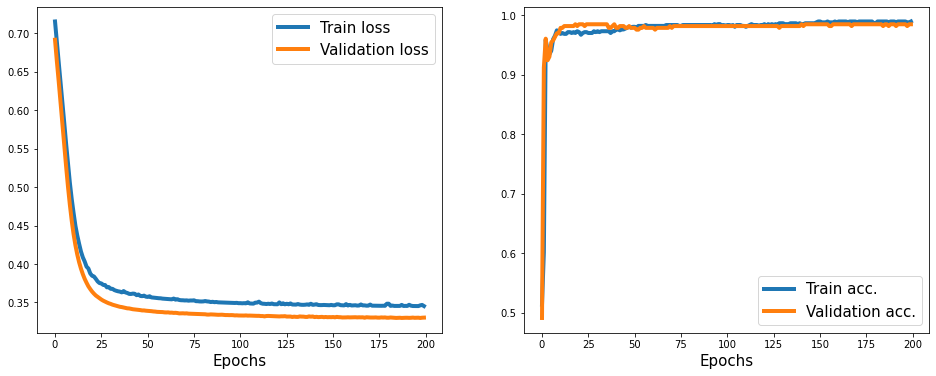

In [23]:
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history["loss_train"], lw=4)
ax.plot(history["loss_valid"], lw=4)
ax.legend(["Train loss", "Validation loss"], fontsize=15)
ax.set_xlabel("Epochs", size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(history["accuracy_train"], lw=4)
ax.plot(history["accuracy_valid"], lw=4)
ax.legend(["Train acc.", "Validation acc."], fontsize=15)
ax.set_xlabel("Epochs", size=15)
plt.show()

As for the **`testing loop`** (evaluating our model), the typical steps include:

<table>
<thead>
  <tr>
    <th>Step Names</th>
    <th>What does it do?</th>
    <th>Code example</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td><b> Forward pass</b></td>
    <td>The model goes through all of the testing data once, performing its forward() function calculations.</td>
    <td><code>model(x_test)</code></td>
  </tr>
  <tr>
    <td><b>Calculate the loss</b></td>
    <td>The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are.</td>
    <td><code>loss = loss_fn(y_pred, y_test)</code></td>
  </tr>
  <tr>
    <td><b>Calulate evaluation metrics (optional)</b></td>
    <td>Alongisde the loss value you may want to calculate other evaluation metrics such as accuracy on the test set.</td>
    <td>Custom functions</td>
  </tr>
</tbody>
</table>

Notice the testing loop doesn't contain performing backpropagation (`loss.backward()`) or stepping the optimizer (`optimizer.step()`), this is because no parameters in the model are being changed during testing, they've already been calculated. For testing, we're only interested in the output of the forward pass through the model.

<div align="center">
<img src="img/01-pytorch-testing-loop-annotated.png" alt="train" width="1000px">
</div>


In [237]:
pred_test = model(X_test)

correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()

print(f"Test Acc.: {accuracy:.4f}")

Test Acc.: 0.4909


## Saving and reloading the trained model


In [238]:
path = "sample_classifier.pt"
torch.save(model, path)

In [239]:
model_new = torch.load(path)
model_new.eval()

Model(
  (layer1): Linear(in_features=2, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=2, bias=True)
)

In [240]:
red_test = model_new(X_test)

correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()

print(f"Test Acc.: {accuracy:.4f}")

Test Acc.: 0.4909


If you want to save only the learned parameters, you can use `save(model.state_dict())` as follows:


In [241]:
path = "classifier_state.pt"
torch.save(model.state_dict(), path)

In [242]:
model_new = Model(input_feature, n_hidden, output_feature)
model_new.load_state_dict(torch.load(path))

<All keys matched successfully>

## Running in GPU


In [258]:
device = torch.device("cpu")  # cuda #cpu
print(device)


X_train = torch.tensor(X_train).float().to(device)
y_train = torch.tensor(y_train).float().to(device)
model = Model().to(device)
model.to(device)

cpu


Model(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=2, bias=True)
)

In [ ]:
%%time
loss_fn = Fn.cross_entropy
opt = optim.SGD(model.parameters(),lr=1)
# fit(x=X_train,y=y_train,model=model,opt=opt,loss_fn=loss_fn)


In [ ]:
%%time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

X_train = torch.tensor(X_train).float().to(device)
y_train = torch.tensor(y_train).float().to(device)
model = Model().to(device)
# fit(x=X_train,y=y_train,model=model,opt=opt,loss_fn=loss_fn)